In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal

import numpy as np
import pandas as pd

import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [125]:
fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

wsrc = '../hpcc/clean/'
dst =  '../hpcc/rotated/'

idname = '2014SBa'
rownum = 5
treenum = 20
nutnum = 8

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(wsrc + bname + '/' + fname + '.tif')

mxval = 2**(8*img.itemsize)

nutvol = np.sum(img > 0) * (resol ** 3)

bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
nutarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
nutvoxarea = np.sum(border)

2014SBa_R5_T20
../hpcc/rotated/2014SBa_R5_T20/
2014SBa_R5_T20_008


In [126]:
filename = dst + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
chnutarea, chnutvol, _ = data[20]

tipvox[0] *= 1 + (-2*rotX)

datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol
rcoords = rotxyz @ datapoints

# Verify rotation

Tip coords:	 [14.13  0.06  0.06]


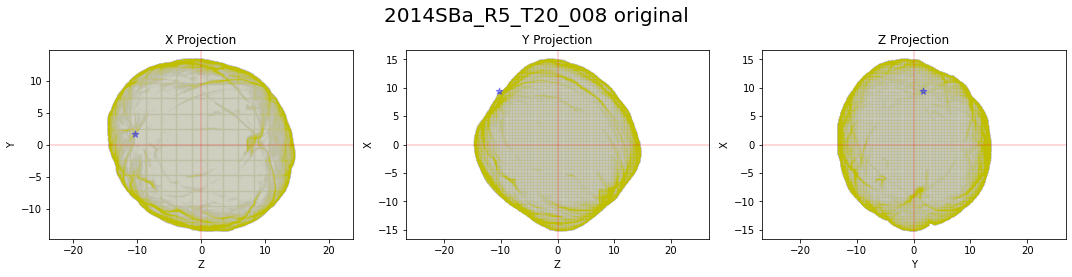

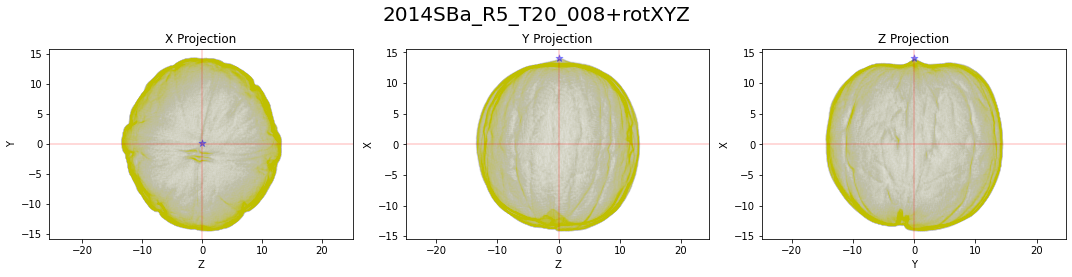

In [127]:
print('Tip coords:\t', np.round(rtipvox, 2))

fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

fig, ax = wnut.plot_3Dprojections(rcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

### Alignment

In [9]:
src = '../hpcc/watershed/'
l2 = [foo[:-15] for foo in np.loadtxt(src + 'protrusion.txt', dtype=str)]
l2

['2008SB_R4_T13/2008SB_R4_T13_001',
 '2008SB_R4_T13/2008SB_R4_T13_002',
 '2008SB_R4_T13/2008SB_R4_T13_003',
 '2008SB_R4_T13/2008SB_R4_T13_004',
 '2008SB_R4_T13/2008SB_R4_T13_005',
 '2008SB_R4_T13/2008SB_R4_T13_006',
 '2008SB_R4_T13/2008SB_R4_T13_007',
 '2008SB_R4_T13/2008SB_R4_T13_008',
 '2008SB_R4_T13/2008SB_R4_T13_009',
 '2008SB_R5_T2/2008SB_R5_T2_001',
 '2008SB_R5_T2/2008SB_R5_T2_002',
 '2008SB_R5_T2/2008SB_R5_T2_003',
 '2008SB_R5_T2/2008SB_R5_T2_004',
 '2008SB_R5_T2/2008SB_R5_T2_005',
 '2008SB_R5_T2/2008SB_R5_T2_006',
 '2008SB_R5_T2/2008SB_R5_T2_007',
 '2008SB_R8_T10/2008SB_R8_T10_001',
 '2008SB_R8_T10/2008SB_R8_T10_002',
 '2008SB_R8_T10/2008SB_R8_T10_003',
 '2008SB_R8_T10/2008SB_R8_T10_004',
 '2008SB_R8_T10/2008SB_R8_T10_005',
 '2010SB_R10_T26/2010SB_R10_T26_001',
 '2010SB_R10_T26/2010SB_R10_T26_002',
 '2010SB_R10_T26/2010SB_R10_T26_003',
 '2010SB_R10_T26/2010SB_R10_T26_004',
 '2010SB_R10_T26/2010SB_R10_T26_005',
 '2010SB_R10_T26/2010SB_R10_T26_006',
 '2010SB_R10_T26/2010SB_R10_T2

In [10]:
src = '../hpcc/watershed/'
l1 = [foo[:-8] for foo in np.loadtxt(src + 'air.txt', dtype=str)]
l1 = set(l1)

l2 = [foo[:-15] for foo in np.loadtxt(src + 'protrusion.txt', dtype=str)]
l2 = set(l2)

#l3 = glob.glob('../hpcc/clean/*')
#l3 = [os.path.split(i)[1] for i in l3]
#l3 = set(l3)

In [11]:
l2 - l1

set()

In [12]:
l1 - l2

{'2012SB_R16_T67/2012SB_R16_T67_006',
 '2012SB_R16_T67/2012SB_R16_T67_007',
 '2014SBa_R5_T20/2014SBa_R5_T20_007',
 '2014SBa_R5_T20/2014SBa_R5_T20_008',
 '2014SBa_R5_T20/2014SBa_R5_T20_009',
 'NewStuke_R1_T17/NewStuke_R1_T17_001',
 'NewStuke_R1_T17/NewStuke_R1_T17_002',
 'NewStuke_R1_T17/NewStuke_R1_T17_003',
 'NewStuke_R1_T17/NewStuke_R1_T17_004',
 'NewStuke_R1_T17/NewStuke_R1_T17_005',
 'NewStuke_R1_T17/NewStuke_R1_T17_006',
 'NewStuke_R1_T17/NewStuke_R1_T17_007',
 'NewStuke_R1_T17/NewStuke_R1_T17_008',
 'NewStuke_R1_T17/NewStuke_R1_T17_009'}